<div style="background-color: RGB(0,90,60);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Análise dos Ingressantes UFABC</h2>
</div>

<div style="border: 1px solid RGB(0,90,60);" >
<h4 style="margin: auto; padding: 3px; color: RGB(0,90,60); ">&nbsp;&nbsp;Base de dados&nbsp;&nbsp;<a href="https://dados.ufabc.edu.br/bases-dados/44-bd-prograd01">Classificação Geral do Ingresso - bd_prograd01</a></h4>
</div>

<div style="border-style: double;border-width: 5px;border-color: RGB(255, 211, 0);" >
<h3 style="margin: auto; padding: 10px; color: RGB(0,0,0); ">Análises Feitas:</h3>
    <div style="margin: auto;padding-left: 40px;padding-bottom: 20px;">
        <lu>
            <li> <a href="#analise1">Cota para pessoas transgênero está mais concorrida</a> </li>
            <li> <a href="#analise2">Mais pessoas entraram na UFABC em 2023</a> </li>
        </lu>
    </div>
</div>
<div style="border: 1px solid RGB(255, 211, 0);" >
<h6 style="margin: auto; padding: 3px; color: RGB(0,90,60); ">&nbsp;&nbsp;Leonardo Dias Trindade da Silva </h6>
</div>

In [159]:
# Pacotes para manipulação dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

# Pacotes nativos do python
from glob import glob
import re

In [121]:
# Definindo fonte das informações
SOURCE = r'./bd_prograd01'
FILES = glob(SOURCE+'/bd_prograd01_*.csv')

# Definindo Cores
verdeUFABC = np.array([0, 90, 60])/255
amaraloUFABC = np.array((255, 211, 0))/255
cinza_claro = np.array([190, 190, 190])/255

In [3]:
# Extração, formatação e limpeza da base
df = pd.concat([pd.read_csv(_file, sep=';', encoding='latin', dtype='str').\
                assign(ano_arquivo = re.search('bd_prograd01_(\d{4}).csv', _file)[1])
                for _file in FILES], ignore_index=True)

df.nota = df.nota.str.replace(',', '.').astype('float64')
df['opção de campus'] = df['opção de campus'].str.upper()
dic = {'Ciência e Tecnologia': 'BACHARELADO EM CIÊNCIA E TECNOLOGIA',
       'Ciências Naturais e Exatas': 'BACHARELADO EM CIÊNCIA E TECNOLOGIA',
       'Ciências e Humanidades': 'BACHARELADO EM CIÊNCIAS E HUMANIDADES',
       'Ciências Humanas': 'BACHARELADO EM CIÊNCIAS E HUMANIDADES'}
df['opção de curso'] = df['opção de curso'].str.rstrip().replace(dic)

<a id='analise1'></a>
# 1. Cota para pessoas transgênero está mais concorrida

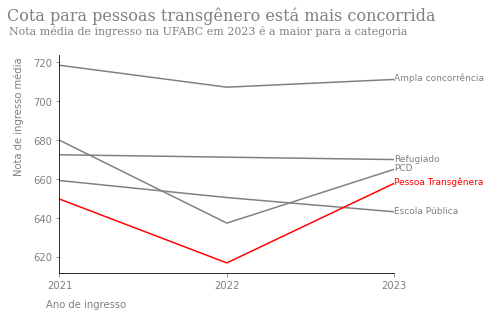

In [143]:
df1 = df.query('ano_arquivo > "2020" and `status de matrícula` == "Matriculado(a)"')\
        .assign(modalidade = df['modalidade convocação']\
        .str.extract('\S* - (?P<c>[^\+]*)').c.str.rstrip())\
        .groupby(['ano_arquivo', 'modalidade'])[['nota']].mean().reset_index()

fig, ax = plt.subplots(facecolor='white')
ax.spines[['right', 'top']].set_visible(False)

last_year = df1.ano_arquivo.max()

for tipo_concorrencia in df1.modalidade.unique():
    c1 = 'red' if tipo_concorrencia == 'Pessoa Transgênera' else 'gray'
    ax.plot('ano_arquivo', 'nota', label=tipo_concorrencia, c=c1,
          data=df1.query('modalidade == @tipo_concorrencia'))
    ax.text(last_year,
          df1.query('ano_arquivo == @last_year and modalidade == @tipo_concorrencia').nota - 0.6,
          tipo_concorrencia, size=9, c=c1)

fig.suptitle('Cota para pessoas transgênero está mais concorrida',
             fontdict = {'family':'serif','color':'gray'}, x=0.5, y=1.05, size=16)
ax.set_title('''Nota média de ingresso na UFABC em 2023 é a maior para a categoria''',
             fontdict = {'family':'serif','color':'gray'}, loc='left', x=-0.15, y=1.07, size=11)

ax.tick_params(colors='gray')

ax.yaxis.label.set_color('gray')
ax.set_ylabel('Nota de ingresso média', ha='left', y=0.45, rotation=90, labelpad=9)

ax.xaxis.label.set_color('gray')
ax.set_xlim(("2021", last_year))
ax.set_xlabel('Ano de ingresso', ha='left', x=-0.04, rotation=0, labelpad=9)

plt.show();

<a id='analise2'></a>
# Mais pessoas entraram na UFABC em 2023

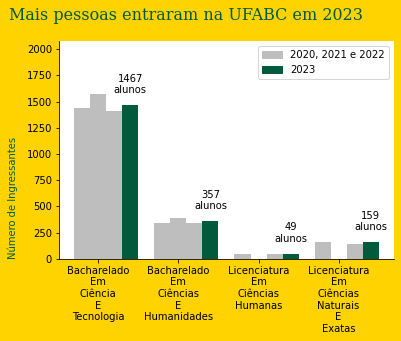

In [170]:
''' Sumarizando # estudantes inscritos dado curso e ano
    Complementando base de dados para anos faltantes
df2 = df.query('`status de matrícula` == "Matriculado(a)"')\
        .groupby(['opção de curso', 'ano_arquivo'])[['inscrição no ENEM']]\
        .count().reset_index()
df2 = pd.merge(pd.DataFrame({'ano_arquivo': df2.ano_arquivo.unique()}),
               pd.DataFrame({'opção de curso': df2['opção de curso'].unique()}), 
               how='cross')\
        .merge(df2, on=['ano_arquivo', 'opção de curso'], how='left').fillna(0)\
        .astype({'inscrição no ENEM': 'int'}) 
'''

# Mesma ação acima, mas feita de maneira mais pythonica
df2 = df.query('`status de matrícula` == "Matriculado(a)"')\
        .rename({'opção de curso':'curso_inscricao', 
                 'ano_arquivo':'ano_inscricao', 
                 'inscrição no ENEM':'n_inscritos'}, axis=1)\
        .pivot_table(values=['n_inscritos'], index=['curso_inscricao'],
                     columns=['ano_inscricao'], aggfunc='count')\
        .fillna(0).stack().reset_index().astype({'n_inscritos':'int'})


fig, ax = plt.subplots(facecolor=amaraloUFABC)
ax.spines[['right', 'top']].set_visible(False)


font1 = {'family':'serif','color':verdeUFABC}
ax.set_title('Mais pessoas entraram na UFABC em 2023',
             fontdict = font1, loc='left', x=-0.15, y=1.07, size=16)

cursos = df2.curso_inscricao.str.title().replace('\s', r'\n', regex=True).unique()
x = np.arange(len(cursos))
width = 0.2
for i, ano in enumerate(df2.ano_inscricao.unique()):
    rects = ax.bar(x + width*i, 
                   df2.query('ano_inscricao == @ano').n_inscritos.to_list(),
                   width, color=verdeUFABC if ano=='2023' else cinza_claro)
    if ano=='2023': ax.bar_label(rects, fmt='{:.0f}\nalunos', label_type='edge', rotation=0, padding=10)


ax.set_xticks(x + width, cursos)

ax.yaxis.label.set_color(verdeUFABC)
ax.set_ylim(0, df2.n_inscritos.max()+500)
ax.set_ylabel('Número de Ingressantes', ha='left', y=0, rotation=90, labelpad=9)


# Legenda manual
outros_anos = mpatches.Patch(color=cinza_claro, label= '2020, 2021 e 2022')
ultimo_ano = mpatches.Patch(color=verdeUFABC, label='2023')
ax.legend(loc='upper right', handles=[outros_anos, ultimo_ano])

plt.show()

<div style="border: 1px solid RGB(0,90,60);" >
<h4 style="margin: auto; padding: 3px; color: RGB(0,90,60); ">&nbsp;&nbsp;Base de dados&nbsp;&nbsp;<a href="https://dados.ufabc.edu.br/bases-dados/44-bd-prograd01">Classificação Geral do Ingresso - bd_prograd01</a></h4>
</div>